In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
from functools import partial

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace, pack_hdf
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
multiplex_base_paths = {
    "vc": os.path.join(base_path, "multiplex_vc_figs"),
    "spk": os.path.join(base_path, "multiplex_rho_figs"),
}
fig_path = os.path.join(base_path, "multiplex_spk_vc_figs")
fig_subdir = None

fig_subdir, analysis_names = ("rho95_vs_rho95flat", {
    "vc": "rho95_vs_rho95flat_rhoreset",
    "spk": "fixed_rho95_vs_rho95flat",
})
fig_subdir, analysis_names = ("ctrl_vs_plex", {
    "vc": "ctrl_vs_plex",
    "spk": "ctrl_vs_plex",
})
# fig_subdir, analysis_names = ("testrng", {
#     "vc": "testrng",
#     "spk": "testrng",
# })
fig_subdir, analysis_names = ("fixedrng", {
    "vc": "fixedrng",
    "spk": "fixedrng",
})

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
analysis_hdfs = {
    k: h5.File(os.path.join(multiplex_base_paths[k], n, "analysis.h5"), "r")
    for k, n in analysis_names.items()
}
d = {k: Workspace(hdf, read_only=True) for k, hdf in analysis_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

# use experiments included in vc since they'll should be a subset of spk (if they differ)
exps = list(d["vc"]["rho_vs_corr_avg"].keys())
rhos = d["vc"]["rhos"][:]

for k, wrk in d.items():
    print("==%s datasets==" % k)
    for name in wrk.keys():
        print(name)
    print("")
    
print("exps:", exps)
print("rhos:", rhos)

==vc datasets==
dir_labels
full_xaxis
residual_corr_full_net_avg
residual_corr_full_net_std
residual_corr_full_peak_net_avg
residual_corr_full_peak_net_std
residual_corr_valid
residual_corr_valid_net_avg
residual_corr_valid_net_std
residual_corr_valid_trial_avg
residuals_ei_sum_neg_area
residuals_ei_sum_pos_area
residuals_neg_area
residuals_pos_area
rho_vs_corr_avg
rho_vs_corr_std
rhos
sac_deltas
sac_thetas
vc_net_avgs
vc_trial_avgs
xaxis

==spk datasets==
avg_dir_spikes
circ_180
dir_labels
dir_sort
dirs_180
dirs_180_sorted
dirs_sorted
metrics
net_mets
rho_avg_dsis
rho_avg_spks
rho_dsis
rho_net_avg_dsis
rho_net_avg_spks
rho_spks
rhos
sac_deltas
sac_thetas
std_dir_spikes
xaxis

exps: ['ctrl']
rhos: [0.   0.2  0.4  0.6  0.8  0.85 0.9  0.92 0.94 0.96 0.98 0.99 1.  ]


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
# list(d["vc"]["residual_corr_full_peak_net_avg"]["ctrl"].keys())
# d["vc"]["rho_vs_corr_avg"]["ctrl"].shape
# d["spk"]["rho_net_avg_dsis"]["ctrl"].shape

dir_labels = d["vc"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
pos_ortho_idx = np.argwhere(dir_labels == 90)[0][0]
neg_ortho_idx = np.argwhere(dir_labels == 270)[0][0]

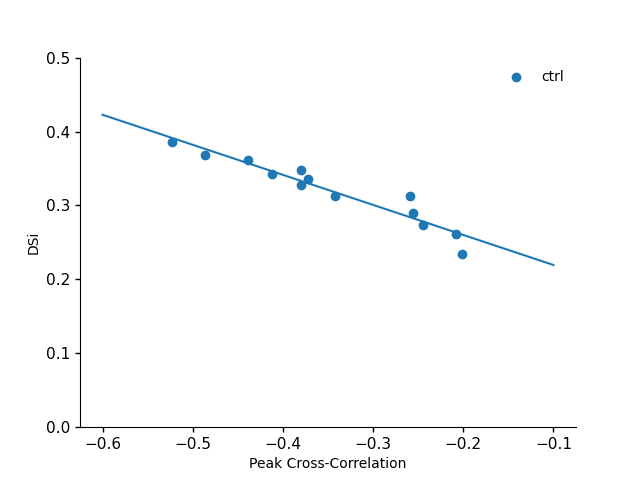

In [8]:
display_exps = exps

avg_corr_vs_dsi_fit_xaxis = np.linspace(-0.6, -0.1, 100)
avg_peak_null_corr_vs_dsi_fig, avg_peak_null_corr_vs_dsi_ax = plt.subplots(1)
for exp in display_exps:
    avg_peak_null_corr_vs_dsi_ax.scatter(
        d["vc"]["rho_vs_corr_avg"][exp][null_idx],
        np.mean(d["spk"]["rho_net_avg_dsis"][exp], axis=-1),
        label=exp,
    )
    fit_coefs = np.polyfit(
        d["vc"]["rho_vs_corr_avg"][exp][null_idx],
        np.mean(d["spk"]["rho_net_avg_dsis"][exp], axis=-1),
        1
    )
    fit = np.poly1d(fit_coefs)(avg_corr_vs_dsi_fit_xaxis)
    avg_peak_null_corr_vs_dsi_ax.plot(avg_corr_vs_dsi_fit_xaxis, fit)

avg_peak_null_corr_vs_dsi_ax.set_ylim(0, 0.5)
avg_peak_null_corr_vs_dsi_ax.set_ylabel("DSi")
avg_peak_null_corr_vs_dsi_ax.set_xlabel("Peak Cross-Correlation")
avg_peak_null_corr_vs_dsi_ax.legend(frameon=False)
clean_axes(avg_peak_null_corr_vs_dsi_ax)

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    avg_peak_null_corr_vs_dsi_fig.savefig(
        os.path.join(fig_path, "avg_peak_null_corr_vs_dsi_%s%s" % (exps_lbl, ext)),
        bbox_inches="tight"
    )

In [ ]:
# peak_null_corr_vs_dsi_fig, peak_null_corr_vs_dsi_ax = plt.subplots(1)
# for exp in exps:
#     peak_null_corr_vs_dsi_ax.scatter(
#         d["vc"]["rho_vs_corr_avg"][exp][null_idx],
#         np.mean(d["spk"]["rho_net_dsis"][exp], axis=-1),
#         label=exp,
#     )

# peak_null_corr_vs_dsi_ax.set_ylim(0, 0.4)
# peak_null_corr_vs_dsi_ax.set_ylabel("DSi")
# peak_null_corr_vs_dsi_ax.set_xlabel("Peak Cross-Correlation")
# peak_null_corr_vs_dsi_ax.legend(frameon=False)
# clean_axes(peak_null_corr_vs_dsi_ax)

shapes (rhos, dirs, nets, trials)
rho_spks: (13, 8, 9, 5)
rho_vs_corr: (13, 8, 9, 5)


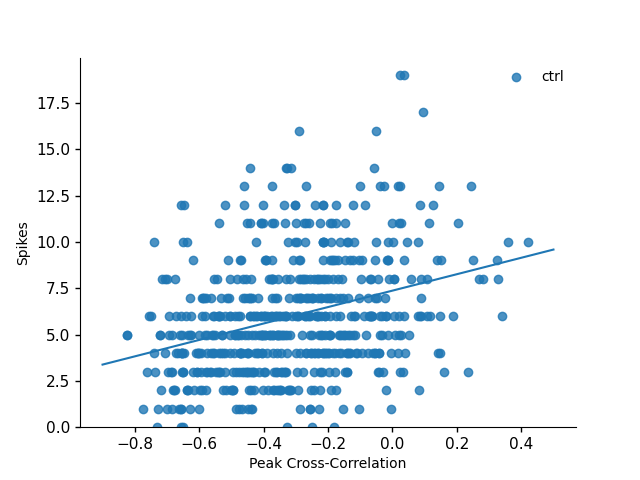

In [14]:
display_exps = exps
display_angle = 180

# NOTE: from the look of this I'm skeptical that the seeds/trials are lineing up with
# eachother properly since plotting the trials against eachother is fitting so much worse than
# the averages.
def reshape_resid_metrics(name):
    return {
        exp: np.array(
            [[d["vc"][name][exp][r][n] for n in d["vc"][name][exp][r].keys()] for r in rhos]
        ).transpose(0, 3, 1, 2)
        for exp in exps
    }
    
resid_ei_pos = reshape_resid_metrics("residuals_ei_sum_pos_area")
resid_ei_neg = reshape_resid_metrics("residuals_ei_sum_neg_area")
rho_vs_corr = reshape_resid_metrics("residual_corr_valid")

_, _, n_spk_nets, n_spk_trials = d["spk"]["rho_spks"]["ctrl"][:].shape
print("shapes (rhos, dirs, nets, trials)")
print("rho_spks:", d["spk"]["rho_spks"]["ctrl"][:].shape)
print("rho_vs_corr:", rho_vs_corr["ctrl"].shape)

dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 
corr_vs_spikes_fit_xaxis = np.linspace(-0.9, 0.5, 100)
# corr_vs_spikes_fit_xaxis = np.linspace(-350, 0, 100)
peak_corr_vs_spks_fig, peak_corr_vs_spks_ax = plt.subplots(1)
for exp in exps:
    peak_corr_vs_spks_ax.scatter(
        rho_vs_corr[exp][:, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1),
        # resid_ei_neg[exp][:, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1),
        d["spk"]["rho_spks"][exp][:, dir_idx].reshape(-1),
        alpha=0.8,
        label=exp,
    )
    fit_coefs = np.polyfit(
        rho_vs_corr[exp][:, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1),
        # resid_ei_neg[exp][:, dir_idx, :n_spk_nets, :n_spk_trials].reshape(-1),
        d["spk"]["rho_spks"][exp][:, dir_idx].reshape(-1),
        1
    )
    fit = np.poly1d(fit_coefs)(corr_vs_spikes_fit_xaxis)
    peak_corr_vs_spks_ax.plot(corr_vs_spikes_fit_xaxis, fit)
    
peak_corr_vs_spks_ax.set_ylim(0)
peak_corr_vs_spks_ax.set_ylabel("Spikes")
peak_corr_vs_spks_ax.set_xlabel("Peak Cross-Correlation")
peak_corr_vs_spks_ax.legend(frameon=False)
clean_axes(peak_corr_vs_spks_ax)

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    peak_corr_vs_spks_fig.savefig(
        os.path.join(fig_path, "peak_corr_vs_spks_%s_dir_%i%s" % (exps_lbl, display_angle, ext)),
        bbox_inches="tight"
    )

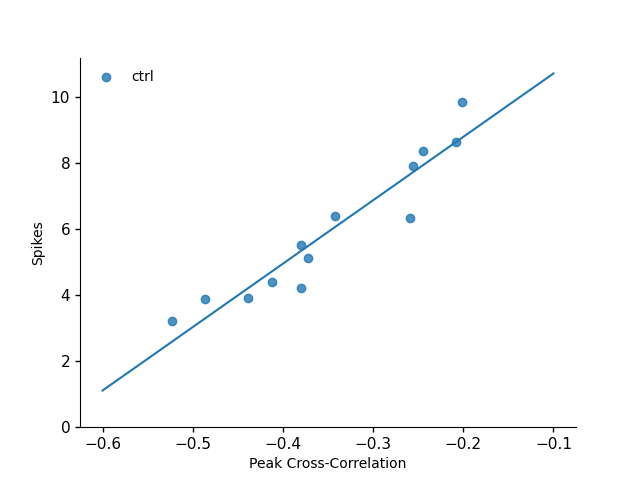

In [11]:
display_exps = exps
display_angle = 180

dir_idx = np.argwhere(dir_labels == display_angle)[0][0] 
avg_corr_vs_spikes_fit_xaxis = np.linspace(-0.6, -0.1, 100)
avg_peak_corr_vs_spks_fig, avg_peak_corr_vs_spks_ax = plt.subplots(1)
for exp in exps:
    avg_peak_corr_vs_spks_ax.scatter(
        d["vc"]["rho_vs_corr_avg"][exp][dir_idx],
        d["spk"]["rho_net_avg_spks"][exp][:, dir_idx].mean(axis=-1),
        alpha=0.8,
        label=exp,
    )
    fit_coefs = np.polyfit(
        d["vc"]["rho_vs_corr_avg"][exp][dir_idx],
        d["spk"]["rho_net_avg_spks"][exp][:, dir_idx].mean(axis=-1),
        1
    )
    fit = np.poly1d(fit_coefs)(avg_corr_vs_spikes_fit_xaxis)
    avg_peak_corr_vs_spks_ax.plot(avg_corr_vs_spikes_fit_xaxis, fit)
    
avg_peak_corr_vs_spks_ax.set_ylim(0)
avg_peak_corr_vs_spks_ax.set_ylabel("Spikes")
avg_peak_corr_vs_spks_ax.set_xlabel("Peak Cross-Correlation")
avg_peak_corr_vs_spks_ax.legend(frameon=False)
clean_axes(avg_peak_corr_vs_spks_ax)

exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    avg_peak_corr_vs_spks_fig.savefig(
        os.path.join(fig_path, "avg_peak_corr_%s_dir_%i%s" % (exps_lbl, display_angle, ext)),
        bbox_inches="tight"
    )

In [ ]:
close_button()

In [16]:
d["vc"]["sac_thetas"]["ctrl"][0.4]["E"][0, :10]

array([298.29893536, 285.76743875,  48.93879644,  36.37234978,
       184.20356614, 253.26267154, 173.82890251, 260.33710751,
       161.77989308, 209.48658353])

In [17]:
d["spk"]["sac_thetas"]["ctrl"][0.4]["E"][0, :10]

array([298.29893536, 285.76743875,  48.93879644,  36.37234978,
       184.20356614, 253.26267154, 173.82890251, 260.33710751,
       161.77989308, 209.48658353])